## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"unzip" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"cat" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [2]:
import pandas as pd
import numpy as np
from typing import Union

d:\Programs\anac\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [4]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [5]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [6]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [7]:
from sklearn.preprocessing import LabelEncoder

user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [8]:
df_train['user_id'].nunique(), df_train['user_id'].max()
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [9]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    result = pd.pivot_table(df, index='user_id', columns='item_id', values='rating', fill_value=0)
    result = result.to_numpy()

    return result #shape ~ [n_users, n_items]

In [10]:
interactions = df_to_matrix(df_train)

In [11]:
from scipy.sparse import coo_array

def df_to_coo(df: pd.DataFrame) -> coo_array:
    result = pd.pivot_table(df, index='user_id', columns='item_id', values='rating', fill_value=0)
    rows, cols = np.where(result >= 0)
    data = result.values[rows, cols]
    result = coo_array((data, (rows, cols)), shape=result.shape)

    return result 

In [12]:
coo_interactions = df_to_coo(df_train)

In [13]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [14]:
from numpy.linalg import svd
from scipy.sparse.linalg import svds

In [15]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)
    try:
        if isinstance(interactions, np.ndarray):
            if n_singular_values == -1:
                U, s, V = svd(interractions)
                shape = interractions.shape
            else:
                U, s, V = svd(interractions, full_matrices=False)
                shape = (n_singular_values, n_singular_values)

            S = np.zeros(shape)
            S[:len(s), :len(s)] = np.diag(s)
        
        else:
            if n_singular_values == -1:
                M, N = interractions.shape
                k = min(M, N) - 1
                U, s, V = svds(interractions, k)
                shape = (k, k)
            else:
                U, s, V = svds(interractions, n_singular_values)
                shape = (n_singular_values, n_singular_values)
            
            S = np.zeros(shape)
            S[:len(s), :len(s)] = np.diag(s)
    except:
        inter = coo_array(interactions)

        if n_singular_values == -1:
            M, N = inter.shape
            k = min(M, N) - 1
            U, s, V = svds(inter, k)
            shape = (k, k)
        else:
            U, s, V = svds(inter, n_singular_values)
            shape = (n_singular_values, n_singular_values)
        
        S = np.zeros(shape)
        S[:len(s), :len(s)] = np.diag(s)
    

    return U, S, V

In [16]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ S @ V, interactions)

In [17]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ S1 @ V1, U @ S @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [18]:
import warnings
warnings.filterwarnings("ignore")
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы 
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал

    #your code here
    U, S, V = make_svd(interractions, n_singular_values)
    preds_matrix = U @ S @ V
    recommendations = []
    try:
        c = interractions[0, :]
        
    except:
        interractions = interractions.todense()
    finally:
        for i in range(0, interractions.shape[0]):
            df = pd.DataFrame(data=(zip(interractions[i, :], preds_matrix[i, :])), columns=['init', 'preds']).sort_values(by='init', ascending=False)
            df['preds'] = df['preds'].astype('float32')

            recommend = df.sort_values(by='preds', ascending=False)
            recommend = recommend[recommend.init == 0].head(top_k)

            recommendations.append(list(recommend.index))
    return np.array(recommendations) #shape ~ [n_users, top_k]

In [19]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [20]:
from sklearn.metrics import ndcg_score

In [21]:
def ndcg_metric(gt_items, predicted):
    
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items['item_id'].values])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)

    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores):
    return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
                  dtype=np.float64)

def evaluate_recommender(df, model_preds, topn=10):
    metric_values = []
    
    for i in range(0, model_preds.shape[0]):
        df_u = df[df['user_id'] == i]
        metric_values.append(ndcg_metric(df_u, model_preds[i]))

    return np.mean(metric_values)

In [22]:
import time
def plot_graphs(interractions: Union[np.ndarray, coo_array], top_k: int = 100):
    df = pd.DataFrame(columns=['NDCG', 'time'])
    for n_singular_values in [1, 10, 50, 200, 1000]:
        time_s = time.time()
        recs = make_svd_recommendations(interractions, n_singular_values, top_k)
        time_e = time.time() - time_s
        ndcg = evaluate_recommender(df_test, recs)
        df.loc[n_singular_values] = {'NDCG': ndcg, 'time': time_e}
    
    print(df)
    lines = df.plot.line(subplots=True)


          NDCG        time
1     0.115364   27.441251
10    0.128137   25.159947
50    0.124020   26.439461
200   0.109943   30.027156
1000  0.064285  249.520120


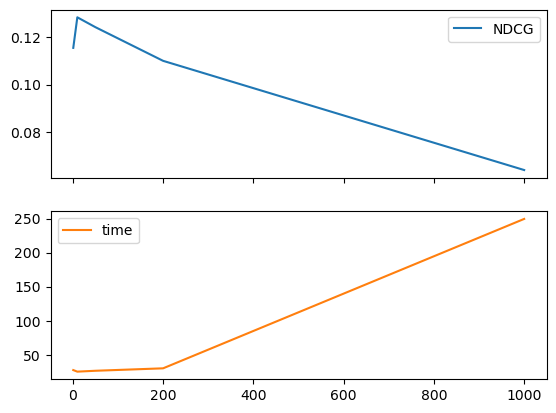

In [23]:
plot_graphs(coo_interactions)

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [24]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix

In [25]:
def make_als_recommendations(
    interractions: Union[np.ndarray, coo_array], 
    top_k: int = 100, 
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    model = AlternatingLeastSquares(random_state = 42, factors = n_factors, alpha = alpha, regularization = regularization)
    datas = csr_matrix(interractions)
    model.fit(datas)
    
    recommendations, scores = model.recommend(np.arange(0, interactions.shape[0]), datas, 100)

    return recommendations #shape ~ [n_users, top_k]

In [26]:
recs = make_als_recommendations(interactions, 100, 50, 0.5, 0.01)
assert recs.shape == (interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [27]:
evaluate_recommender(df_test, recs)

0.12428725513459839

Со стандартными гиперпараметрами метрика NDCG равна 0.118115. Если в SVD использовать сингулярные числа от 10 до 50 включительно, то метрика NDCG у модели будет больше, чем у iALS. В остальных случаях метрика была ниже.

С гиперпараметрами factors = 50, alpha = 0.5, regularization = 0.01 NDCG равняется 0.124287. Это значениы больше расчитанных значений результатов SVD при использовании различных сингулярных чисел.

##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [ ]:
model = AlternatingLeastSquares(random_state = 42, factors = 50, alpha = 0.5, regularization = 0.01)
datas = csr_matrix(interactions)
model.fit(datas)

movies = pd.read_csv("ml-1m/movies.dat", sep='::', names= ['item_id', 'name (year)', 'tags'], engine='python', encoding='utf-8', index_col='item_id')


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
users = [2, 10, 24]
for u in users:
    print(f'Объяснение рекомендаций для {u}-го юзера:')
    print(f'Топ 3 рекомендации c объяснениями для юзера:')
    n = 1
    user_weights=None
    N_count = 10
    
    for mov in recs[u][:3]:
        print(f'{n} - {movies.loc[mov]["name (year)"]}')

        total_score, top_contributions, user_weights = model.explain(u, datas, mov, user_weights=user_weights, N = N_count)
        df_u = df_train[df_train.user_id == u]
        merge_item = []
        for t in top_contributions:
            if df_u[df_u.item_id == t[0]].shape[0] > 0:
                merge_item.append(t)
        
        print(f'Данная рекомендация с вероятностью {round(total_score, 3)} должна понравиться пользователю. Ранее пользователь взаимодействовал с {len(merge_item)} похожими фильмами из {N_count}:')
        for m in merge_item:
            print(f'{movies.loc[m[0]]["name (year)"]} - рейтинг схожести {round(m[1], 3)}')

        n += 1

        print('')


Объяснение рекомендаций для 2-го юзера:
Топ 3 рекомендации c объяснениями для юзера:
1 - Brother Minister: The Assassination of Malcolm X (1994)
Данная рекомендация с вероятностью 0.832 должна понравиться пользователю. Ранее пользователь взаимодействовал с 10 похожими фильмами из 10:
Beautiful Girls (1996) - рейтинг схожести 0.099
What Happened Was... (1994) - рейтинг схожести 0.092
Dear God (1996) - рейтинг схожести 0.078
Wend Kuuni (God's Gift) (1982) - рейтинг схожести 0.06
Much Ado About Nothing (1993) - рейтинг схожести 0.054
Ninotchka (1939) - рейтинг схожести 0.052
JLG/JLG - autoportrait de d�cembre (1994) - рейтинг схожести 0.047
Browning Version, The (1994) - рейтинг схожести 0.045
Scout, The (1994) - рейтинг схожести 0.042
Class (1983) - рейтинг схожести 0.038

2 - Night of the Living Dead (1968)
Данная рекомендация с вероятностью 0.648 должна понравиться пользователю. Ранее пользователь взаимодействовал с 10 похожими фильмами из 10:
Girls Town (1996) - рейтинг схожести 0.106

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [102]:
var1 = df_train.copy()
var2 = df_train.copy()
var3 = df_train.copy()
var4 = df_train.copy()

In [103]:
var1.rating = var1.rating.apply(lambda x: 1)
var2.rating = var2.rating.apply(lambda x: 1 if x>=4 else 0)
var3.rating = var3.rating.apply(lambda x: 1 if x>=4 else -1)

In [104]:
max = var4.datetime.max()
var4['diff_dt'] = var4.datetime.apply(lambda x: round((max - x)/pd.Timedelta(days=30), 0))
var4.rating = var4.apply(lambda x: 1 if (x['rating'] >= 4) else -1 + 0.6 ** x['diff_dt'], axis =  1)

In [107]:
datasets = [var1, var2, var3, var4]
n = 1
for d in datasets:
    inter = df_to_matrix(d)
    time_f = time.time()
    recs_svd = make_svd_recommendations(inter, 10, 100)
    time_s = time.time()
    recs_als = make_als_recommendations(inter, 100, 50, 0.5, 0.01)
    time_t = time.time()
    ndcg_svd = evaluate_recommender(df_test, recs_svd)
    ndcg_als = evaluate_recommender(df_test, recs_als)

    print(f'Для {n}-го варианта:')
    print(f'SVD: NDCG = {ndcg_svd}, time = {round(time_s - time_f)}')
    print(f'iALS: NDCG = {ndcg_als}, time = {round(time_t - time_s)}\n')

    n += 1

  0%|          | 0/15 [00:00<?, ?it/s]

Для 1-го варианта:
SVD: NDCG = 0.12813713415955272, time = 97
iALS: NDCG = 0.12193254149403424, time = 7



  0%|          | 0/15 [00:00<?, ?it/s]

Для 2-го варианта:
SVD: NDCG = 0.11865799457613709, time = 82
iALS: NDCG = 0.11691010783648544, time = 3



  0%|          | 0/15 [00:00<?, ?it/s]

Для 3-го варианта:
SVD: NDCG = 0.12813713415955272, time = 85
iALS: NDCG = 0.12379684900232171, time = 5



  0%|          | 0/15 [00:00<?, ?it/s]

Для 4-го варианта:
SVD: NDCG = 0.1240801474199982, time = 82
iALS: NDCG = 0.12081147044092835, time = 4



Для всех вариантов метод SVD оказался более лучшим по метрике NDCG, но во всех вариантах разница небольшая - от 2 до 6 тысячных. Но время работы функции сильно отличается - SVD обучалась и предсказывала от 80 секунд, а метод iALS до 10 секунд максимум.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [41]:
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef = 0.01):
        #your code here

    def fit(self, interractions: np.ndarray, n_iterations: int 10):
        #your code here

    def predict(self, top_k: int = 100):
        # возвращает top-k айтемов для каждого юзера(айтемы с которыми юзер взаимодействовал не должны попасть в рекомендации)
        #your code here

        return predicts # shape ~ [n_users, top_k]

IndentationError: expected an indented block after function definition on line 2 (3105765018.py, line 5)